## PROJET  MU4MA029 2023 - 2024

$\underline{\text{Nom}} \text{ : Fromentin}$

$\underline{\text{Prénom}} \text{ : Théo}$

$\underline{\text{Numéro Étudiant}} \text{ : 21306056}$

In [2]:
import matplotlib.pyplot as plt #Utile pour l'affichage (cf. Partie 1).
import matplotlib.tri as mtri #Utile pour les triangulations (cf. Partie 4).

import numpy as np
from numpy import linalg as LA #Utile pour le calcul de normes (cf. Partie 2). 

from scipy.sparse import csr_matrix #Utile pour les matrices creuses (cf. Partie 2). 
#Alternatives : 
#from scipy.sparse import coo_matrix
#from scipy.sparse import lil_matrix

from scipy.linalg import toeplitz #Utile pour la matrice de Masse (cf. Partie 2). 
from scipy.sparse.linalg import spsolve #Utile pour la résolution du système linéaire (cf. Partie 4). 


### 1. Géométrie

#### Question a)

Ci-dessous une routine permettant de générer une maillage triangulaire uniforme pour un rectangle de taille $L_x \times L_y$. 

L'idée de cet algorithme est la suivante : 
1) Création des sommets. On parcourt le rectangle de gauche à droite et de bas en haut. À chaque pas de la subdivision horizontale on ajoute à $\text{vtx}$ un nouveau point, tout en étant vigilant d'être encore à l'intérieur du rectangle. 
2) Création des cellules. On parcourt toujours le rectangle de gauche à droite et de bas en haut. À chaque tour de boucle, on va ajouter deux triangles à $\text{elt}$, l'un supérieur et l'autre inférieur.  

In [3]:
def GenerateRectangleMesh(Lx, Ly, Nx, Ny):
    vtx = [] #Liste vide visant à contenir les sommets du maillage.
    elt = [] #Liste vide visant à contenir les cellules du maillage. 
    Nv = (Nx+1) * (Ny+1) #Cas particulier des maillages sur un rectangle 
    
    hx = Lx/Nx #Pas de la subdivision sur l'axe des abscisses. 
    hy = Ly/Ny #Pas de la subdivision sur l'axe des ordonnées. 
    x = 0. 
    y = 0.
    noeuds = 0
    kx = 0
    while noeuds < Nv:
        vtx.append([x,y])
        
        if kx==Nx:
            x=0.
            kx=0
            y+=hy
            
        else:
            x+=hx
            kx+=1
            
        noeuds+=1

    for j in range(Ny):
        for i in range(Nx):
            s0 = j*(Nx+1) + i
            s1 = j*(Nx+1) + i+1
            s2 = (j+1) * (Nx+1) + i+1
            elt.append( [ s0, s1, s2 ] ) #Triangle inférieur (en dessous de la diagonale).

            s0 = j*(Nx+1) + i 
            s1 = (j+1) * (Nx+1) + i+1 
            s2 = (j+1) * (Nx+1) + i
            elt.append( [ s0, s1, s2] ) #Triangle supérieur.
            
    return vtx,elt

vtx,elt = GenerateRectangleMesh(1,1,2,2)
print("vtx = \n", vtx)
print("elt = \n", elt)

vtx = 
 [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 0.5], [0.5, 0.5], [1.0, 0.5], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]]
elt = 
 [[0, 1, 4], [0, 4, 3], [1, 2, 5], [1, 5, 4], [3, 4, 7], [3, 7, 6], [4, 5, 8], [4, 8, 7]]


#### Question b)

L'objectif est de développer une routine $\text{GeometricRefinement} $ permettant de raffiner une (ou plusieurs) fois un maillage, uniquement à l'origine. 
Pour ce faire, je vais créer deux fonctions d'aide $\text{Refine}$ et $\text{Refine2}$ qui seront directement incorporées dans $\text{GeometricRefinement}$.

Le maillage ici est ordonné de telle sorte que lors qu'un élément de $\text{elt}$ contient l'indice $0$, un de ses sommets est l'origine du repère. Voici l'idée de mon algorithme : 

1) On définit une liste vide que nous allons remplir avec les élements à l'origine. La structure du maillage impose qu'il n'existe que $2$ éléments dans cette liste. 
2) On calculera 3 millieux : $\text{millieu1}$, $\text{millieu2}$ et $\text{millieu3}$, qui seront ajoutés à la liste des sommets. Ils seront calculés de telle sorte à utiliser uniquement les sommets de triangle inférieur, pour éviter les problèmes d'orientation. J'y reviendrai.
3) On ajoute les éléments dans le sens trigométrique en partant du triangle inférieur gauche, tout en prenant garde que le maillage soit bien conforme (au sens de l'orientation). Concrètement, cela signifique si l'on prend $\tau_1$ et $\tau_2$ deux éléments du maillage d'arête commune $f$, de sommets $s_1$ et $s_2$. La conformité du maillage impose que $\tau_1$ doit parcourir dans le sens $s_1$ puis $s_2$, ainsi que $\tau_2$ dans l'autre sens. 

In [4]:
def Refine(vtx, elt):
    refined_vtx = vtx.copy()  
    refined_elt = []
    l = len(vtx) #Nombre de sommets dans le maillage avant raffinement. 
    
    elt_origine=[] #Liste vide visant à contenir les cellules à l'origine (0,0)
    for e in elt:
        if 0 in e: #Mon maillage est ordonné de sorte que 0 correspond à (0,0)
            elt_origine.append(e)
        else :
            refined_elt.append(e) #On l'ajoute directement aux éléments du maillage raffiné (pas de modification)
            
    e1=elt_origine[0] 
    #print("Premier élément contenant l'origine : ", e1)
    e2=elt_origine[1]
    #print("Second élément contenant l'origine : ", e2)
    
    millieu1 = [(vtx[e1[0]][0] + vtx[e1[1]][0]) / 2, (vtx[e1[0]][1] + vtx[e1[1]][1]) / 2]
    millieu2 = [(vtx[e1[0]][0] + vtx[e1[2]][0]) / 2, (vtx[e1[0]][1] + vtx[e1[2]][1]) / 2]
    # Mauvaise idée : millieu3 = [(vtx[e2[0]][0] + vtx[e2[2]][0]) / 2, (vtx[e2[0]][1] + vtx[e2[1]][1]) / 2]
    millieu3 = [millieu1[1],millieu1[0]] #On inverse les coordonnées pour obtenir les millieu situé sur l'axe des ordonnées.
    #print("millieu1 : " , millieu1)
    #print("millieu2 : " , millieu2)
    #print("millieu3 : ", millieu3) 
    
    refined_vtx.append(millieu1)
    refined_vtx.append(millieu2)
    refined_vtx.append(millieu3)
    
    refined_elt.append([e1[0],l,l+1])
    refined_elt.append([l+1,l,e1[1]])
    refined_elt.append([e1[2],l+1,e1[1]])
    refined_elt.append([e1[2],e2[2],l+1]) 
    refined_elt.append([e2[2],l+2,l+1])
    refined_elt.append([l+2,e1[0],l+1])
    
    return [refined_vtx, refined_elt]

vtx,elt = GenerateRectangleMesh(1,1,2,2)
new_vtx, new_elt = Refine(vtx, elt)
print("vtx = \n", vtx)
print("elt = \n", elt)
print("new_vtx = \n", new_vtx)
print("new_elt = \n", new_elt)

vtx = 
 [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 0.5], [0.5, 0.5], [1.0, 0.5], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]]
elt = 
 [[0, 1, 4], [0, 4, 3], [1, 2, 5], [1, 5, 4], [3, 4, 7], [3, 7, 6], [4, 5, 8], [4, 8, 7]]
new_vtx = 
 [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 0.5], [0.5, 0.5], [1.0, 0.5], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0], [0.25, 0.0], [0.25, 0.25], [0.0, 0.25]]
new_elt = 
 [[1, 2, 5], [1, 5, 4], [3, 4, 7], [3, 7, 6], [4, 5, 8], [4, 8, 7], [0, 9, 10], [10, 9, 1], [4, 10, 1], [4, 3, 10], [3, 11, 10], [11, 0, 10]]


Comme je l'ai précédemment expliqué, l'ordre est important. Le triangle inférieur à l'origine est bien ordonné tandis que le triangle supérieur l'est au bout du second raffinement. Lors du premier raffinement, l'ordre au sein du triangle supérieur fait une rotation dans le sens anti-trigonométrique. 
Il faut alors prendre en compte ce comportement dans la routine $\text{Refine2}$. Hormis cet aspect, le principe est le même.

Je vous joins en plus de ce notebook un fichier $\text{refinement.pdf}$ illustrant mon propos.

In [7]:
def Refine_2(vtx, elt):
    
    refined_vtx = vtx.copy()  
    refined_elt = []
    l = len(vtx)  
    
    elt_origine=[]
    for e in elt:
        if 0 in e:
            elt_origine.append(e)
        else :
            refined_elt.append(e)
            
    e1=elt_origine[0]
    e2=elt_origine[1]

    millieu1 = [(vtx[e1[0]][0] + vtx[e1[1]][0]) / 2, (vtx[e1[0]][1] + vtx[e1[1]][1]) / 2]
    millieu2 = [(vtx[e1[0]][0] + vtx[e1[2]][0]) / 2, (vtx[e1[0]][1] + vtx[e1[2]][1]) / 2]
    millieu3 = [millieu1[1],millieu1[0]]
     
    refined_vtx.append(millieu1)
    refined_vtx.append(millieu2)
    refined_vtx.append(millieu3)
    
    refined_elt.append([e1[0],l,l+1])
    refined_elt.append([l+1,l,e1[1]])
    refined_elt.append([e1[2],l+1,e1[1]])
    refined_elt.append([e1[2],e2[0],l+1]) 
    refined_elt.append([e2[0],l+2,l+1])
    refined_elt.append([l+2,e1[0],l+1])
    
    return [refined_vtx, refined_elt]

vtx,elt = GenerateRectangleMesh(2,2,2,2)
new_vtx2, new_elt2 = Refine_2(new_vtx,new_elt)
print("new_vtx = \n", new_vtx)
print("new_elt = \n", new_elt)
print("new_vtx2 = \n", new_vtx2)
print("new_elt2 = \n", new_elt2)

new_vtx = 
 [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 0.5], [0.5, 0.5], [1.0, 0.5], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0], [0.25, 0.0], [0.25, 0.25], [0.0, 0.25]]
new_elt = 
 [[1, 2, 5], [1, 5, 4], [3, 4, 7], [3, 7, 6], [4, 5, 8], [4, 8, 7], [0, 9, 10], [10, 9, 1], [4, 10, 1], [4, 3, 10], [3, 11, 10], [11, 0, 10]]
new_vtx2 = 
 [[0.0, 0.0], [0.5, 0.0], [1.0, 0.0], [0.0, 0.5], [0.5, 0.5], [1.0, 0.5], [0.0, 1.0], [0.5, 1.0], [1.0, 1.0], [0.25, 0.0], [0.25, 0.25], [0.0, 0.25], [0.125, 0.0], [0.125, 0.125], [0.0, 0.125]]
new_elt2 = 
 [[1, 2, 5], [1, 5, 4], [3, 4, 7], [3, 7, 6], [4, 5, 8], [4, 8, 7], [10, 9, 1], [4, 10, 1], [4, 3, 10], [3, 11, 10], [0, 12, 13], [13, 12, 9], [10, 13, 9], [10, 11, 13], [11, 14, 13], [14, 0, 13]]


Il reste donc à construire $\text{GeometricRefinement}$. On sépare alors le cas du premier raffinement des autres. 

In [8]:
def GeometricRefinement(vtx,elt,r) : 
    for i in range (r) : 
        if(i==0) :
            vtx,elt = Refine(vtx,elt)
        else : 
            vtx,elt = Refine_2(vtx,elt) 
    return vtx,elt 

#### Question c) 

Voici la routine $\text{PlotMesh}$, directement empruntée du TP2.

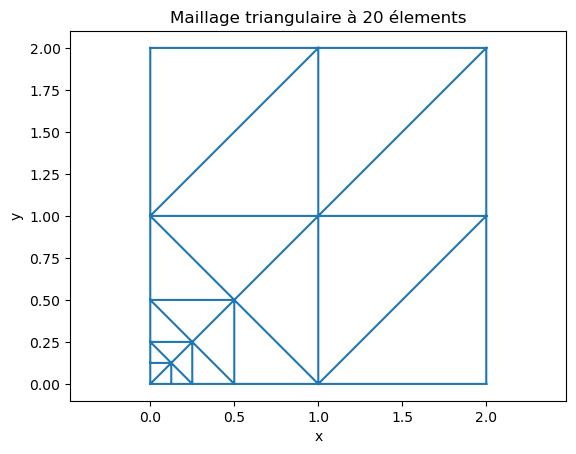

In [9]:
def PlotMesh(vtx,elt) :
    X=[vtx[i][0] for i in range (len(vtx))]
    Y=[vtx[j][1] for j in range (len(vtx))]
    #on extrait resp. les 1ere et 2nd composantes 
    #print(len(Y))
    #print(len(X))
    #print("Il y a "+str(len(elt))+" éléments dans le maillage.")
    plt.triplot(X,Y,elt)
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend
    plt.title("Maillage triangulaire à {} élements".format(len(elt)) )
    
vtx,elt = GenerateRectangleMesh(2,2,2,2)
vtx2,elt2 = GeometricRefinement(vtx,elt,3)
PlotMesh(vtx2,elt2)

Ci-dessous la définition des routines $\text{Boundary}$ et $\text{PlotMeshBoundary}$ permettant d'extraire les arêtes se situant au bord et de les afficher. 

La fonction $\text{PlotMeshBoundary}$ ne sera pas utile pour la suite, elle est juste là pour tester $\text{Boundary}$.

En effet nous aurons besoin plus tard dans le projet de traiter différemment les conditions de bord. 

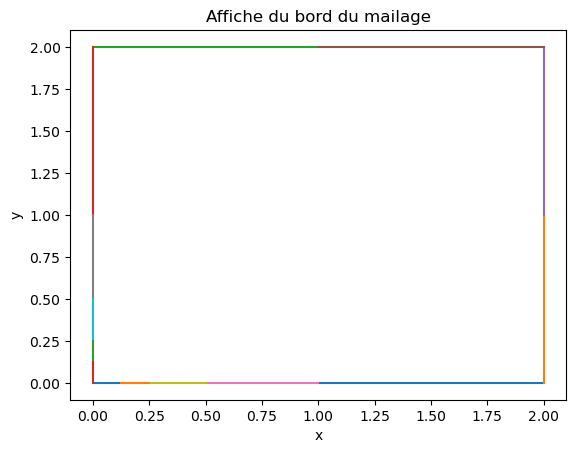

In [10]:
def Boundary(elt):
    D = {} #Dictionnaire vide visant à contenir les arêtes sur le bord ainsi la table de correspondance 
    Nc = len(elt) #Nombre de cellules 

    for i in range(Nc):
        
        s0 = int(elt[i][0]) 
        s1 = int(elt[i][1])  
        s2 = int(elt[i][2]) 
        
        b0=(s0,s1) #arête n°2
        b1=(s1,s2) #arête n°0
        b2=(s2,s0) #arête n°1 
        L = (b0,b1,b2) #Liste contenant les 3 arêtes du i-ème triangle 
    

        for k,b in zip([2,0,1], L):
            if b not in D.keys(): #Si l'arête b n'est pas dans D on l'ajoute avec la clée suivante. 
                D[b] = 3*i+k
            else : #Si b est déjà dans D, elle apparait plusieurs fois donc n'est pas dans le bord. 
                D.pop(b)
            if b[::-1] in D.keys(): #Si l'inverse de b est dans D, on enlève b et son inverse. 
                D.pop(b[::-1])
                D.pop(b)
        
    
    eltb = list(D.keys())
    be2e = list(D.values())
    #Conversion des list en tableaux numpy 
    eltb = np.array(eltb)
    be2e = np.array(be2e)
        
    #return eltb,be2e 
    return eltb #Ici seul eltb nous interesse.

def PlotMeshBoundary(vtx, eltb) : 
    
    for e in eltb : #on boucle sur toutes les arêtes dans le bord 
        P1=e[0] #premier sommet de l'arête 
        P2=e[1] #second sommet de l'arête 
        x1=vtx[P1][0] #on extrait la première coordonnée du premier sommet de l'arête 
        y1=vtx[P1][1] #on extrait la seconde coordonnée du premier sommet de l'arête 
        x2=vtx[P2][0]
        y2=vtx[P2][1]
        plt.plot([x1,x2],[y1,y2])
    plt.title("Affiche du bord du mailage")    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show() #on met bien ceci à la fin de la boucle afin que toutes les arêtes soient affichées sur le même graphe

boundary = Boundary(elt2)
PlotMeshBoundary(vtx2,boundary)

### 2. Problème

#### Question a)

En tenant compte de la condition au bord de Dirichlet homogène, on choisit comme espace 
variationnel $H_0^1(\Omega) := \text{ker}(\tau_{\partial \Omega})$.
Dans l'écriture de $(BVM)$ on suppose tacitement que $\mu \nabla u \in H(div,\Omega)$.
Autrement dit, on impose plus que simplement $u \in H^1(\Omega)$. En réalité $u \in H^1(\Omega)\cap H^1(\Delta,\Omega)$.
$\newline$ 
En multipliant l'EDP du volume de $\Omega$ par $v \in H_0^1(\Omega)$ puis en intégrant : 
$\newline$
$ \int_{\Omega} -\bar{v}\text{div}(\mu \nabla u) + u\bar{v}\,dx = \int_{\Omega} f\bar{v} \, dx$
$\newline$
En utilisant la formule de Green (dont l'utilisation est permise car $\nabla u \in H(\text{div},\Omega)$) et en tenant compte de la nullité sur le bord, on a :  
$\newline$
$\int_{\Omega} \mu \nabla \bar{v}^t \nabla u + u\bar{v} \,dx = \int_{\Omega} f\bar{v} \, dx$

$\Longleftrightarrow a(u,v)=l(v)$
$\newline$ 
On obtient alors la formulation variationelle suivante : 

$(VF) :$ $\left\{
    \begin{array}{l}
        \text{Trouver } u \in H^1_0(\Omega) \text{ tel que :} \\
        a(u,v) = l(v) \quad \forall v \in H^1_0(\Omega)
    \end{array}
\right.
$

Réciproquement, supposons que $u$ est solution de $(VF)$. Alors par définition $u=0$ sur $\partial \Omega$.
Prenons $v \in \mathcal{C}_{O,K}^{\infty}(\Omega) \subset H_0^1(\Omega)$. On a donc l'égalité suivante : 


$\int_{\Omega} \mu \nabla \bar{v}^t \nabla u \,dx = \int_{\Omega} (f-u)\bar{v} \, dx$. 

Par hypothèse $f \in \mathbb{L}^2(\Omega)$, et comme $u \in H_0^1(\Omega)$, $f-u \in \mathbb{L}^2(\Omega)$.


Ainsi par définition de la divergence faible, $\mu\nabla u \in H(\text{div}, \Omega)$ et $-\text{div}(\mu\nabla u) = f-u$.


On obtient ainsi l'équivalence entre $(BVM)$ et $ (VF)$.

La formulation variationelle discrète est la suivante :

$\left\{
    \begin{array}{l}
        \text{Trouver } u_h \in V_h^{\partial \Omega} \text{ tel que :} \\
        a(u_h,v_h) = l(v_h) \quad \forall v_h \in V_h^{\partial \Omega}
    \end{array}
\right.$
, où $ V_h^{\partial \Omega} = V_h \cap H_0^1(\Omega)$ 

Soient $(\phi_j)_{j=1..N}$ une base $V_h^{\partial \Omega}$. Par linéarité on en déduit que cette formulation est équivalente à : 

$\left\{
    \begin{array}{l}
        \text{Trouver } u_h \in V_h^{\partial \Omega} \text{ tel que :} \\
        a(u_h,\phi_j) = l(\phi_j) \quad \forall j = 1,...,N_v
    \end{array}
\right.$

On en déduit alors en décomposant $u_h$ dans cette base la forme matricielle : 

$\left\{
    \begin{array}{l}
        \text{Trouver } U \in \mathbb{C}^{N} \text{ tel que :} \\
        A \cdot U = F
    \end{array}
\right.$, où $A_{j,k} = a(\phi_k, \phi_j)$ et $F_j = l(\phi_j)$.


______

On peut même montrer que le problème est bien posé pour une fonction $\mu$ vérifiant les hypothèses de l'énnoncé.


 - Hypothèse 1 : $H_0^1(\Omega) = \text{ker}(\tau_{\partial \Omega})$, qui est un sous espace fermé en tant que noyau d'une application continue (cf. théorème de trace). De plus comme $H_0^1(\Omega) \subset H^1(\Omega)$ qui est un espace de Hilbert, on en déduit que $H_0^1(\Omega)$ est également un espace de Hilbert.
 
$\newline$ 
 
 - Hypothèse 2 : $l(v) = \int_{\Omega} f\bar{v} \, dx$. Ainsi par l'inégalité de Cauchy - Schwarz, $|l(v)| \leq \|v\|_{\mathbb{L}^2}\|f\|_{\mathbb{L}^2} \leq \|f\|_{\mathbb{L}^2}\|v\|_{H^1(\Omega)}$, d'où la continuité de $l(.)$.
 
$\newline$

- Hypothèse 3 : Comme $\sup_{x \in \Omega} \mu(x) < +\infty$, $\exists M > 0 $ tel que $\forall x \in \Omega$, on ait $\mu(x) < M$.
Ainsi par Cauchy-Schwarz : $|a(u,v)| \leq M\|\nabla u\|_{\mathbb{L}^2}\|\nabla v\|_{\mathbb{L}^2}+\| u\|_{\mathbb{L}^2}\|v\|_{\mathbb{L}^2} \leq (1+M)\|u\|_{H^1(\Omega)}\|v\|_{H^1(\Omega)}$, d'où la continuité de $a(.,.)$.

$\newline$
 
 - Hypothèse 4 : Comme $\inf_{x \in \Omega} \mu(x) > 0$, $\exists \epsilon > 0$ tel que $\forall x \in \Omega$, on ait $\mu(x)>\epsilon$. 
Ainsi, $\Re {a(u,u)} \geq \epsilon \|\nabla u\|_{\mathbb{L}^2}^2+\|u\|_{\mathbb{L}^2}^2 \geq \epsilon \|\nabla u\|_{\mathbb{L}^2}^2$. 
En utilisant le cas particulier de l'inégalité de Poincaré dans $H_0^1(\Omega)$ : $ \exists \alpha > 0$ tel que  $\alpha \|u\|_{\mathbb{L}^2}^2 \leq \|\nabla u\|_{\mathbb{L}^2}^2 \forall u \in H_0^1(\Omega)$. Notons que $\alpha =1$ aurait suffit. L'utilisation de cette inégalité est permise car $\Omega$ est un domaine borné, et lispchitzien (il est même $\mathcal{C}^1$ par morceaux).
(NB : on aurait aussi pu le montrer en utilisant la fonction $\Phi(v) =  \sqrt(\int_{\partial\Omega} |v|^2\, d\sigma)$). On en tire que : $|a(u,u)| \geq \Re {a(u,u)} \geq \frac{\epsilon}{2}\min (\alpha,1)\|u\|_{H^1(\Omega)}^2$, d'où la coercivité de $a(.,.)$.

$\underline{\text{Conclusion}}$ : Par le théorème de Lax-Milgram, il existe une unique solution. 

______
On peut même aller encore plus loin. Le maillage étant conforme (continuité aux points de "raccordement"), on a l'inclusion $ V_h^{\partial \Omega} \subset H_0^1(\Omega) $. Comme $\dim(V_h^{\partial \Omega}) \leq N_v < \infty$ (en réalité de dimension égale à $N_v-N_v^{\partial \Omega}$), on en déduit que  $ V_h^{\partial \Omega}$ est lui aussi un espace de Hilbert, en tant que sous ensemble de dimension finie d'un espace de Hilbert. En restreignant $a(.,.)$ et $l(.)$ aux points de l'espace variationnel discret considéré, le théorème de Lax-Milgram s'applique une nouvelle fois pour affirmer qu'il y a existence & unicité de la solution au problème variationnel discret. 

#### Question b)

$\underline{\text{Matrice de Masse}}$ : 

On remarque que la matrice de masse est une matrice de Toeplitz. C'est un cas particulier des matrices à bandes, que nous avons évoqué en cours. 
Ainsi, la matrice de masse élémentaire $M^{\tau}$ admet comme expression : 

$M_{j,k}^{\tau}=\int_{\tau} \phi_j^{\tau} \phi_k^{\tau} \,dx$

En utilisant le Lemme 8.1 : $\int_{\tau} \phi_0^{\tau}(x)^{\alpha_0}...\phi_n^{\tau}(x)^{\alpha_n} \, dx = \frac{n!\alpha_0!...\alpha_n!}{(n+\alpha_0+...+\alpha_n)!}|\tau|$, il vient que :
$M^{\tau} = \frac{|\tau|}{12}
\begin{pmatrix}
2 & 1 & 1 \\
1 & 2 & 1 \\
1 & 1 & 2 \\
\end{pmatrix}
$

In [14]:
##Matrice de Masse : 
def Mloc(vtx, e) : 
    if(len(e)==3) : 
        mat=toeplitz(np.array([2,1,1]))/12
        #L'aire du triangle ABC est par définition la norme du produit vectoriel AB v AC 
        """ 
        Écrire ici : 
        T=LA.norm(np.cross(vtx[e[0]] - vtx[e[1]], vtx[e[1]] - vtx[e[2]]))/2
        L'opérateur - n'étant pas défini pour les list 
        On doit convertir les list en tableau numpy pour les soustraire 
        """
        T=LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2 # par défaut la norme 2
        #print (T)
    
        return T*mat

def Mass(vtx, elt) :
    
    vtx = np.array(vtx)
    elt = np.array(elt)
    
    Nv=len(vtx) #Nombre de sommets.
    
    Nc=len(elt) #Nombre de cellules.
    d=len(elt[0]) 
    
    #print ("Nv={}".format(Nv))
    #print("Nc={}".format(Nc))
    #print("d={}".format(d))
    
    I = np.zeros(d*d*Nc)
    J = np.zeros(d*d*Nc)
    V = np.zeros(d*d*Nc)
    
    k=0 
    
    for q in range(Nc):
        Ml = Mloc(vtx, elt[q])
        for l in range(d):
            for m in range(d):
                I[k] = elt[q,l]
                J[k] = elt[q,m]
                V[k] = Ml[l,m]
                k+=1
    return csr_matrix( (V, (I,J) ) , shape=(Nv,Nv) )

vtx, elt = GenerateRectangleMesh(1,1,2,2)
#On utilise la methode toarray() pour afficher la matrice complétée de 0. 
print(Mass(vtx,elt).toarray())

[[0.04166667 0.01041667 0.         0.01041667 0.02083333 0.
  0.         0.         0.        ]
 [0.01041667 0.0625     0.01041667 0.         0.02083333 0.02083333
  0.         0.         0.        ]
 [0.         0.01041667 0.02083333 0.         0.         0.01041667
  0.         0.         0.        ]
 [0.01041667 0.         0.         0.0625     0.02083333 0.
  0.01041667 0.02083333 0.        ]
 [0.02083333 0.02083333 0.         0.02083333 0.125      0.02083333
  0.         0.02083333 0.02083333]
 [0.         0.02083333 0.01041667 0.         0.02083333 0.0625
  0.         0.         0.01041667]
 [0.         0.         0.         0.01041667 0.         0.
  0.02083333 0.01041667 0.        ]
 [0.         0.         0.         0.02083333 0.02083333 0.
  0.01041667 0.0625     0.01041667]
 [0.         0.         0.         0.         0.02083333 0.01041667
  0.         0.01041667 0.04166667]]


Test sur la masse : 
$\newline$ 
$U^TMU=|\Omega|$ où $U=(1,...1)$.

Notons que des erreurs d'arrondis peuvent intervenir. 

In [15]:
## Test Matrice de masse : 
vtx,elt = GenerateRectangleMesh(5,5,10,10)
new_vtx,new_elt = GeometricRefinement(vtx,elt,2)
Nv = len(new_vtx)
U = np.ones(Nv)
print("U^t * M * U = ", U@Mass(new_vtx,new_elt)@U)
print("Aire du domaine : ",5*5) 

U^t * M * U =  24.999999999999996
Aire du domaine :  25


$\underline{\text{Matrice de ""Rigidité""}}$ : 

On va approcher $\mu$ par $\Pi_h \mu$, l'interpolant en $\mathbb{P}_1$ - Lagrange, admettant comme expression : 
$ \Pi_h(\mu)(x)=\sum_{i=0}^n \mu(s_j^h)\phi_j^h(x)$.
$\newline$
J'ai fait le choix de l'incorporer directement dans la construction de la matrice de rigidité et non lors de l'assemblage total de la matrice. Mais comme cet opérateur est linéaire (c'est en fait une projection), cela ne change pas le test sur la ridigité.

$K_{i,j}^{\tau}=\int_{\tau} \mu \nabla (\phi_j^{\tau})^T \nabla \phi_k^{\tau} \,dx$. 
$\newline$ 
Ici on a l'approximation (par le choix fait précédemment) : 
$\newline$
$\int_{\tau} \nabla (\phi_j^{\tau})^T \nabla \phi_k^{\tau} \sum_{i=1}^d \mu(s_i^{\tau})\phi_i^{\tau}(x)\,dx$. 
$\newline$Le champ vectoriel étant constant en tant que gradient d'une fonction linéaire, et par linéarité : 
$\nabla \phi_j^t \nabla \phi_k \sum_{i=1}^d \mu(s_i^{\tau}) \int_{\tau}\phi_i^{\tau}(x)\,dx$.
On utilise la formule suivante : (pour un n-simplexe, dans notre cas n=2 puisque ce sont des triangles) :
$\newline$
$\int_{\tau} \phi_0^{\tau}(x)^{\alpha_0}...\phi_n^{\tau}(x)^{\alpha_n} \, dx = \frac{n!\alpha_0!...\alpha_n!}{(n+\alpha_0+...+\alpha_n)!}|\tau|$.
$\newline$ 
Ce qui permet de conclure que : 
$K_{i,j}^{\tau} \approx \nabla (\phi_j^{\tau})^t \nabla \phi_k^{\tau}\sum_{i=1}^d \mu(s_i^{\tau})\frac{|\tau|}{3}$

Nous aurons besoin de : 


$  \nabla (\phi_j^{\tau})^t \nabla \phi_k^{\tau} = \frac{n_j^{\tau} \cdot n_k^{\tau}}{[(s_j^{\tau}-s_{j+1}^{\tau}) \cdot n_j^{\tau}][(s_k^{\tau}-s_{k+1}^{\tau}) \cdot n_k^{\tau}]}$

Où ici, $d=2$ donc $n_j^{\tau} = e_3 \times (s_{j+1}^{\tau}-s_{j+2}^{\tau})$, avec $e_3=(0,0,1)$

In [18]:
def mu(x,y,Lx,Ly) : 
    return 2+np.sin(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly)

In [19]:
#Matrice de "rigidité" locale 
def Kloc(vtx,mu,e,Lx,Ly) : 
    K = np.zeros(shape=(3,3)) #Matrice 3 x 3 à remplir. 
    T = np.linalg.norm(np.cross(vtx[e[0]]-vtx[e[1]], vtx[e[1]]-vtx[e[2]]))/2 #Volume du simplexe.
    integral = (mu(vtx[e[0]][0],vtx[e[0]][1],Lx,Ly)+mu(vtx[e[1]][0],vtx[e[1]][1],Lx,Ly)+mu(vtx[e[2]][0],vtx[e[2]][1],Lx,Ly))*T/3 #Approx. Lagrange
    for i in range(3) : 
        ni = np.cross(np.array([0,0,1]), vtx[e[(i+1)%3]]-vtx[e[(i+2)%3]])[:2]
        K[i,i] = np.dot(ni,ni)/( np.dot(vtx[e[i]]-vtx[e[(i+1)%3]],ni)**2) #Terme diagonal. 
        for j in range(i+1,3) : 
            nj = np.cross(np.array([0,0,1]),vtx[e[(j+1)%3]]-vtx[e[(j+2)%3]])[:2]
            K[i,j] = np.dot(ni,nj)/ ( np.dot(vtx[e[j]]  - vtx[e[(j+1)%3]], nj)*np.dot(vtx[e[i]] - vtx[e[(i+1)%3]], ni))
            K[j,i]=K[i,j]
    return K*integral

Lx = 1
Ly = 1
Nx = 2
Ny = 2
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
vtx = np.array(vtx)
print(vtx[elt[0]][0],vtx[elt[0]][1],vtx[elt[0]][2])
print(Kloc(vtx,mu,elt[0],Lx,Ly))

[0. 0.] [0.5 0. ] [0.5 0.5]
[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]


In [20]:
##Assemblage pour une matrice de "rididité" globale.
def Rig(vtx, elt, mu, Lx, Ly) : 
    
    vtx = np.array(vtx)
    elt = np.array(elt)
    
    Nv=len(vtx) #Nombre de sommets. 
    
    Nc=len(elt) #Nombre de cellules. 
    d=len(elt[0]) 
    
    #print ("Nv={}".format(Nv))
    #print("Nc={}".format(Nc))
    #print("d={}".format(d))

    I = np.zeros(d*d*Nc) #Pour les lignes.
    J = np.zeros(d*d*Nc) #Pour les colonnes. 
    V = np.zeros(d*d*Nc)
    
    k=0 
    
    for q in range(Nc):
        Ml = Kloc(vtx,mu, elt[q],Lx,Ly)
        for l in range(d):
            for m in range(d):
                I[k] = elt[q,l]
                J[k] = elt[q,m]
                V[k] = Ml[l,m]
                k+=1
    return csr_matrix( (V, (I,J) ) , shape=(Nv,Nv) )


vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
test = Rig(vtx,elt,mu,Lx,Ly)
#On utilise la methode toarray() pour afficher la matrice complétée de 0. 
print(test.toarray()) 

[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0. -2.  0.  0.  0.  0.]
 [ 0. -1.  2.  0.  0. -1.  0.  0.  0.]
 [-1.  0.  0.  4. -2.  0. -1.  0.  0.]
 [ 0. -2.  0. -2.  8. -2.  0. -2.  0.]
 [ 0.  0. -1.  0. -2.  4.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -2.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  2.]]


Test sur la rigidité : 
$\newline$ 
$U^TKU=0$, où $U=(1,...1)_{N}$
$\newline$
Ce test peut renvoyer une valeur (très) proche de 0, à cause des erreurs d'arrondi, notamment pour un maillage plus fin comme nous allons le constater. 

In [21]:
Lx = 1 
Ly = 1 
Ny = 2 
Nx = 2 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
test = Rig(vtx,elt,mu,Lx,Ly)
U = np.ones(test.shape[0])
print("Test sur la ridigité : ", U@test@U)

Lx = 1
Ly = 1 
Ny = 10
Nx = 10 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
test2 = Rig(vtx,elt,mu,Lx,Ly)
U = np.ones(test2.shape[0])
print("Test sur la rigidité : ", U@test2@U)

new_vtx,new_elt = GeometricRefinement(vtx,elt,6)
test3 = Rig(new_vtx,new_elt, mu,Lx,Ly)
U = np.ones(test3.shape[0])
print("Test sur la ridigité : ", U@test3@U)

Test sur la ridigité :  0.0
Test sur la rigidité :  -1.0658141036401503e-14
Test sur la ridigité :  -1.0436096431476471e-14


#### Question c)

Étant donné que par définition, $A^0_{j,k} = a(\phi_k, \phi_j)$, il suffit de sommer les matrices obtenues précédemment. 

In [22]:
def A0(mu,Lx,Ly,Nx,Ny) :
    vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
    K = Rig(vtx,elt,mu,Lx,Ly)
    M = Mass(vtx,elt)
    return K + M

Lx = 1 
Ly = 1 
Nx = 2 
Ny = 2 
print(A0(mu,Lx,Ly,Nx,Ny).toarray())

[[ 2.04166667 -0.98958333  0.         -0.98958333  0.02083333  0.
   0.          0.          0.        ]
 [-0.98958333  4.0625     -0.98958333  0.         -1.97916667  0.02083333
   0.          0.          0.        ]
 [ 0.         -0.98958333  2.02083333  0.          0.         -0.98958333
   0.          0.          0.        ]
 [-0.98958333  0.          0.          4.0625     -1.97916667  0.
  -0.98958333  0.02083333  0.        ]
 [ 0.02083333 -1.97916667  0.         -1.97916667  8.125      -1.97916667
   0.         -1.97916667  0.02083333]
 [ 0.          0.02083333 -0.98958333  0.         -1.97916667  4.0625
   0.          0.         -0.98958333]
 [ 0.          0.          0.         -0.98958333  0.          0.
   2.02083333 -0.98958333  0.        ]
 [ 0.          0.          0.          0.02083333 -1.97916667  0.
  -0.98958333  4.0625     -0.98958333]
 [ 0.          0.          0.          0.          0.02083333 -0.98958333
   0.         -0.98958333  2.04166667]]


La matrice $A^0$ obtenue ne convient pas totalement au problème posé. Il faut pour cela utiliser la "pseudo-élimination" afin de, encore une fois, traiter différement les termes de bord. Pour ce faire, il faut "isoler" les noeuds sur le bord, en mettant à 0 les lignes / colonnes, et à 1 le coefficient diagonal. Il faudra bien sûr adopter un traitement similaire dans le second membre (en mettant à 0 à l'indice correspondant aux  sommets concernés). À la fin, on obtiendra obtenir la condition de bord sans dépendre des autres valeurs dans la forme matricielle, en "forçant" en quelque sorte les solutions à s'annuler sur le bord. C'est la raison pour laquelle au lieu de mettre 1 sur le terme diagonal, on aurait en réalité pu mettre n'importe quel $x \in \mathbb{R}^*$.

In [24]:
def A(mu,Lx,Ly,Nx,Ny) : 
    vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
    A_0 = A0(mu, Lx,Ly,Nx,Ny)
    Nv = A_0.shape[0] #nombre de sommets dans le maillage 
    d = len(elt[0]) #dimension 
    Nc = len(vtx) #nombre de cellules dans le maillage 
    bord = Boundary(elt) #arêtes sur le bord 
    A1 = csr_matrix(A_0)
    for i in range(Nv) : #pesudo-élimination 
        if i in bord : 
            A1[i,:]=0
            A1[:,i]=0
            A1[i,i] = 1 
    return csr_matrix(A1)

print(A(mu,Lx,Ly,Nx,Ny).toarray())

[[1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    8.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


### 3. Second membre

#### Question a)

- $u_{ex}(x,y) = (xy)^\alpha(x - L_x)(y - L_y)$


- $\mu(x,y) = 2 + \sin\left(\frac{2\pi x}{L_x}\right)\sin\left(\frac{4\pi y}{L_y}\right)$
$\newline$
- $\frac{\partial u_{ex}}{\partial x} = \left\{
    \begin{array}{ll}
        y(y - L_y)(2x - L_x) & \text{si } \alpha=1 \\
        \alpha y (y-L_y)(x-L_x)(xy)^{\alpha-1}+(y-L_y)(xy)^{\alpha} & \text{sinon}
    \end{array}
\right.$

- $ \frac{\partial u_{ex}}{\partial y} = \left\{
    \begin{array}{ll}
        x(x - L_x)(2y - L_y) & \text{si } \alpha=1 \\
        \alpha x (x-L_x)(y -L_y)(xy)^{\alpha-1}+(x-L_x)(xy)^{\alpha} & \text{sinon}
    \end{array}
\right.$

$\newline$
- $\frac{\partial^2 u_{ex}}{\partial x^2} =\left\{
    \begin{array}{ll}
        2y(y-L_y) & \text{si } \alpha=1 \\
         y^2(y-L_y)(2(x-L_x)+4x) & \text{si } \alpha=2 \\
        (y - L_y)\left((\alpha - 1)\alpha y^2(x - L_x)(xy)^{\alpha - 2} + 2\alpha y(xy)^{\alpha - 1}\right) & \text{sinon} 
    \end{array}
\right.$
$\newline$
- $\frac{\partial^2 u_{ex}}{\partial y^2} =\left\{
    \begin{array}{ll}
        2x(x-L_x) & \text{si } \alpha=1 \\
         x^2(x-L_x)(2(y-L_y)+4y) & \text{si } \alpha=2 \\
        (x - L_x)\left((\alpha - 1)\alpha x^2(y - L_y)(xy)^{\alpha - 2} + 2\alpha x(xy)^{\alpha - 1}\right) & \text{sinon} 
    \end{array}
\right.$

- $\frac{\partial \mu}{\partial x} = \frac{2\pi}{L_x}\sin\left(\frac{4\pi y}{L_y}\right)\cos\left(\frac{2\pi x}{L_x}\right)$
- $\frac{\partial \mu}{\partial y} = \frac{4\pi}{L_y}\cos\left(\frac{4\pi y}{L_y}\right)\sin\left(\frac{2\pi x}{L_x}\right)$


In [25]:
def u(x,y,a,Lx,Ly) : 
    return (x*y)**a*(x-Lx)*(y-Ly) 
    
def mu(x,y,Lx,Ly) : 
    return 2+np.sin(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly) 


def partial_u_x(x,y,a,Lx,Ly) : 
    if(a == 1) :
        return y*(y-Ly)*(2*x-Lx) 
    else : 
        return a*y*(y-Ly)*(x-Lx)*(x*y)**(a-1)+(y-Ly)*(x*y)**a 
    
def partial_u_y(x,y,a,Lx,Ly) : 
    #if(a==1): 
    #    return x*(2*y-Ly)*(x-Lx) 
    #else :
    #    return a*x*(y-Ly)*(x-Lx)*(x*y)**(a-1)+(x-Lx)*(x*y)**a 
    return partial_u_x(y,x,a,Ly,Lx)

def partial_2_u_x(x,y,a,Lx,Ly) : 
    if(a==1) : 
        return 2*y*(y-Ly)
    elif(a==2) : 
        return y**2*(y-Ly)*(2*(x-Lx)+4*x)
    else : 
        return (y-Ly)*((a-1)*a*y**2*(x-Lx)*(x*y)**(a-2)+2*a*y*(x*y)**(a-1))
    
    
def partial_2_u_y(x,y,a,Lx,Ly) : 
    #if(a==1) : 
    #    return 2*x*(x-Lx)
    #elif(a==2):
    #    return x**2*(2*(y-Ly)+4*y)*(x-Lx)
    #else : 
    #    return (x-Lx)*((a-1)*a*x**2*(y-Ly)*(x*y)**(a-2)+2*a*x*(x*y)**(a-1))
    return partial_2_u_x(y,x,a,Ly,Lx)

def partial_mu_x(x,y,Lx,Ly) : 
    return 2*np.pi/Lx*np.sin(4*np.pi*y/Ly)*np.cos(2*np.pi*x/Lx)  

def partial_mu_y(x,y,Lx,Ly) : 
    return 4*np.pi/Ly*np.cos(4*np.pi*y/Ly)*np.sin(2*np.pi*x/Lx) 


In [26]:
a = 2/3 
Lx = 1
Ly = 1 
print("u(0.5,0.5,2/3,1,1) = ",u(0.5,0.5,2/3,1,1))
print("mu(0.5,0.5,1,1) = ",mu(0.5,0.5,Lx,Ly))
print("partial_u_x(0.5,0.5,2/3,1,1) = ",partial_u_x(0.5,0.5,2/3,1,1))
print("partial_u_y(0.5,0.5,2/3,1,1) = ",partial_u_y(0.5,0.5,2/3,1,1))
print("partial_2_u_x(0.5,0.5,2/3,1,1) = ",partial_2_u_x(0.5,0.5,2/3,1,1))
print("partial_2_u_y(0.5,0.5,2/3,1,1) = ",partial_2_u_y(0.5,0.5,2/3,1,1))
print("partial_mu_x(0.5,0.5,1,1) = ",partial_mu_x(0.5,0.5,Lx,Ly))
print("partial_mu_y(0.5,0.5,1,1) = ",partial_mu_y(0.5,0.5,Lx,Ly))

u(0.5,0.5,2/3,1,1) =  0.09921256574801247
mu(0.5,0.5,1,1) =  2.0
partial_u_x(0.5,0.5,2/3,1,1) =  -0.06614171049867498
partial_u_y(0.5,0.5,2/3,1,1) =  -0.06614171049867498
partial_2_u_x(0.5,0.5,2/3,1,1) =  -0.6173226313209665
partial_2_u_y(0.5,0.5,2/3,1,1) =  -0.6173226313209665
partial_mu_x(0.5,0.5,1,1) =  1.5389365549774318e-15
partial_mu_y(0.5,0.5,1,1) =  1.5389365549774318e-15


#### Question b)

$u_{ex}$ étant solution : 
on sait que $-\text{div}(\mu\nabla u_{ex})+u_{ex} = f$ dans $\Omega$.
$\newline$
$\Longleftrightarrow -\mu \text{div}(\nabla u_{ex})-\nabla \mu ^t \nabla u_{ex} + u_{ex} = f$ dans $\Omega$.
$\newline$
$\Longleftrightarrow -\mu \Delta u_{ex}-\nabla \mu ^t \nabla u_{ex} + u_{ex} = f$ dans $\Omega$. 
$\newline$
$\Longleftrightarrow -\mu(x,y)(\frac{\partial^2 u_{ex}}{\partial x^2}+\frac{\partial^2 u_{ex}}{\partial y^2})-
\frac{\partial \mu}{\partial x}\frac{\partial u_{ex}}{\partial x}-\frac{\partial \mu}{\partial y}\frac{\partial u_{ex}}{\partial y}+u_{ex}(x,y)= f$ dans $\Omega$.

In [30]:
def f(x,y,a,Lx,Ly) : 
    
    return -(mu(x,y,Lx,Ly)*(partial_2_u_x(x,y,a,Lx,Ly)+partial_2_u_y(x,y,a,Lx,Ly))+partial_mu_x(x,y,Lx,Ly)*partial_u_x(x,y,a,Lx,Ly)+partial_mu_y(x,y,Lx,Ly)*partial_u_y(x,y,a,Lx,Ly))+u(x,y,a,Lx,Ly)

f(0.5,0.5,2/3,1,1)

2.5685030910318787

#### Question c)

L'évaluation de f au bord du domaine pose problème (division par 0). Pour remédier à cela, on va utiliser une règle de quadrature qui n'utilise pas les termes de bord. Ce qui n'est pas le cas de l'interpolation $\mathbb{P}_1$ - Lagrange, faisant intervenir les sommets du maillage.
On choisit ici la règle de quadrature suivante : 

$\int_{\tau} g(x) \, dx \approx g\left(\frac{s_0^{\tau}+s_1^{\tau}+s_2^{\tau}}{3}\right)|\tau|$


On appliquant à $g=f\phi_j$, où $\phi_j$ fonction de forme. 
$\newline$
On remarque que $\phi_j\left(\frac{s_0^{\tau}+s_1^{\tau}+s_2^{\tau}}{3}\right) = \frac{1}{3}$. Montrons le.
$\newline$

En effet, $\phi_j$ est linéaire.  
Donc $\phi_j = a^Tx+b$, où $a \in \mathbb{C}^2$ et $b \in \mathbb{C}$
$\newline$
Prenons le simplexe $\tau$ de sommets $s_j^{\tau},s_{j+1}^{\tau},s_{j+2}^{\tau}$. 
Par définition, $\phi(s_j^{\tau})=1$, donc $a^Ts_j^{\tau}=1-b$.
De même, comme $\phi(s_{j+1}^{\tau})=0$ et $\phi(s_{j+2}^{\tau})=0$, on a $a^Ts_{j+1}^{\tau}=-b$ et $a^Ts_{j+2}^{\tau}=-b$. 
$\newline$
Au final par linéarité : 
$\newline$
$\phi_j\left(\frac{s_j^{\tau}+s_{j+1}^{\tau}+s_{j+2}^{\tau}}{3}\right) = \frac{1}{3}(1-b-b-b)+b = \frac{1}{3}$

Pour construire le second membre, on va suivre la même idée que pour assembler la matrice de masse / rigidité. 
Créons une fonction locale, puis à l'aide de celle-ci une fonction globale en ajoutant chaque contribution. Ici j'ai fait le choix d'incorporer directement la pseudo-elimination au coeur de l'assemblage (contrairement au membre de gauche où j'ai implémenté $A^0$). 

In [32]:
def F_loc(vtx, mu, e, a, Lx,Ly):
    vtx=np.array(vtx)
    d = len(e) 
    s = vtx[e] #Sommets de l'élément e. 
    T = LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2
    F = np.zeros(d)
    for i in range (d) : 
            F[i] = f((s[0][0]+s[1][0]+s[2][0])/3,(s[0][1] +s[1][1]+s[2][1])/3,a,Lx,Ly)*T/3
    return F 

vtx, elt = GenerateRectangleMesh(1,1,2,2)
Lx = 1
Ly = 1
a = 2/3
b = 1 
vtx=np.array(vtx)
s= vtx[elt[0]]
print("Coordonnées des sommets du premier triangle : \n", s[0],s[1],s[2])
print("Test des évaluations avec les barycentres :")
print(f((s[0][0]+s[1][0]+s[2][0])/3,(s[0][1] +s[1][1]+s[2][1])/3,a,Lx,Ly))
print(f((s[0][0]+s[1][0]+s[2][0])/3,(s[0][1] +s[1][1]+s[2][1])/3,b,Lx,Ly))
print("F_loc(vtx,mu,elt[0], a, Lx,Ly) = ", F_loc(vtx,mu,elt[0], a, Lx,Ly))

Coordonnées des sommets du premier triangle : 
 [0. 0.] [0.5 0. ] [0.5 0.5]
Test des évaluations avec les barycentres :
7.117760866649895
2.949066648595671
F_loc(vtx,mu,elt[0], a, Lx,Ly) =  [0.29657337 0.29657337 0.29657337]


In [33]:
def F_global(mu,a, Lx, Ly, Nx, Ny) : 
    vtx,elt=GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    elt = np.array(elt)
    Nv = len(vtx) #Nombre de sommets. 
    Nc = len(elt) #Nombre de cellules. 
    d=len(elt[0]) 
    F1 = np.zeros(Nv)
    bord = Boundary(elt)
    F1 = np.array(F1)
    for q in range(Nc):
        Fl = F_loc(vtx,mu, elt[q],a, Lx,Ly)
        for l in range(d):        
            j = elt[q,l] 
            F1[j] += Fl[l] 
    #Prise en compte des conditions de Dirichlet : pseudo-élimination. 
    for i in range(Nv) : 
        if i in bord : 
            F1[i]=0
    return F1 
                
a = 1 
Lx = 1
Ly = 1
Nx = 2 
Ny = 2
vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
print("F_global(mu,a,Lx,Ly,Nx,Ny) = \n",F_global(mu,a,Lx,Ly,Nx,Ny))

F_global(mu,a,Lx,Ly,Nx,Ny) = 
 [0.         0.         0.         0.         0.56916547 0.
 0.         0.         0.        ]


### 4. Résolution

#### Question a)

On résout de le système sous forme matriciel donné par la méthode de Galerkin. Il en résulte le vecteur solutuion $\text{U} = (u_0, ..., u_N)$.

In [39]:
def Uh(a,mu,Lx,Ly,Nx,Ny) :  
    return spsolve (A(mu, Lx,Ly,Nx,Ny), F_global(mu,a,Lx,Ly,Nx,Ny))

In [40]:
print("Uh(2/3,mu,1,1,4,4) = \n", Uh(2/3,mu,1,1,4,4))
print("__________________________________________________________________\n")
print("Uh(1,mu,1,1,4,4) = \n", Uh(1,mu,1,1,4,4))

Uh(2/3,mu,1,1,4,4) = 
 [0.         0.         0.         0.         0.         0.
 0.07949322 0.08894898 0.05445946 0.         0.         0.08670969
 0.09220297 0.06290115 0.         0.         0.05664654 0.06209323
 0.04010477 0.         0.         0.         0.         0.
 0.        ]
__________________________________________________________________

Uh(1,mu,1,1,4,4) = 
 [0.         0.         0.         0.         0.         0.
 0.03266083 0.04488121 0.03189603 0.         0.         0.04486443
 0.05784707 0.04486443 0.         0.         0.03189603 0.04488121
 0.03266083 0.         0.         0.         0.         0.
 0.        ]


#### Question b)

In [43]:
def PlotApproximation(a,mu,Lx,Ly,Nx,Ny) : 
    U = Uh(a,mu,Lx,Ly,Nx,Ny) #Solution approchée. 
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx) #Conversion en tableau numpy (bi-dimensionnel). 
    X = vtx[:,0] #Abscisses.
    Y = vtx[:,1] #Ordonnées.
    triangulation = mtri.Triangulation(X,Y,elt) 
    plt.tripcolor(triangulation, U,label="Solution approchée")
    plt.title("Solution approchée, alpha={}, Nx={} et Ny={}".format(a,Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()
    
    

def PlotSolutionExacte(a,mu,Lx,Ly,Nx,Ny):
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    X = vtx[:,0] #Abscisses.
    Y = vtx[:,1] #Ordonnées.
    triangulation = mtri.Triangulation(X, Y, elt)
    Uex = np.array([u(x,y,a,Lx,Ly) for (x,y) in vtx]) #Solution exacte. 
    plt.tripcolor(triangulation, Uex,label="Solution Exacte")
    plt.title("Solution exacte, alpha={},Nx={} et Ny={}".format(a,Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()

 
    
def PlotErreur(a,mu,Lx,Ly,Nx,Ny):
    vtx, elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
    vtx = np.array(vtx)
    X = vtx[:,0]
    Y = vtx[:,1]
    U = Uh(a,mu,Lx,Ly,Nx,Ny) #Solution approchée.
    triangulation = mtri.Triangulation(X, Y, elt)
    Uex = np.array([u(x,y,a,Lx,Ly) for (x,y) in vtx]) #Solution exacte. 
    plt.tripcolor(triangulation, abs(Uex-U), shading='flat',label="Erreur")
    plt.title("Erreur en valeur absolue, alpha={},Nx={} et Ny={}".format(a,Nx,Ny))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.colorbar()
    
 

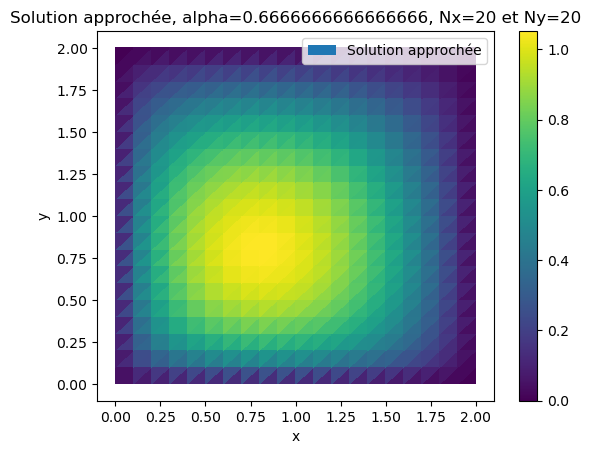

In [44]:
PlotApproximation(2/3,mu,2,2,20,20)

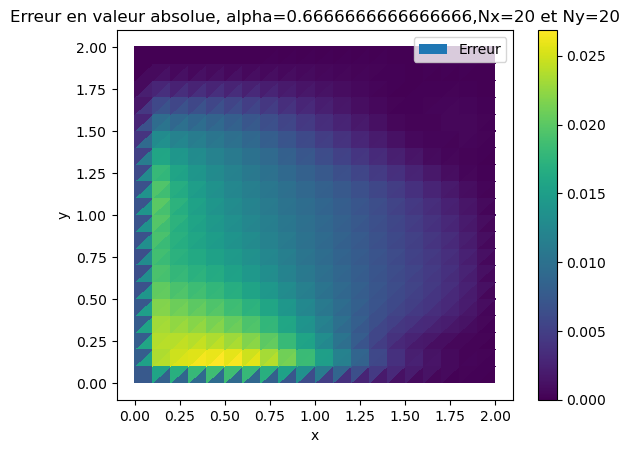

In [45]:
PlotErreur(2/3,mu,2,2,20,20)

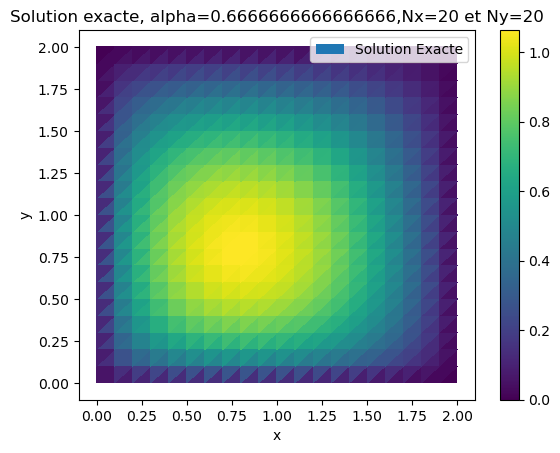

In [46]:
PlotSolutionExacte(2/3,mu,2,2,20,20)

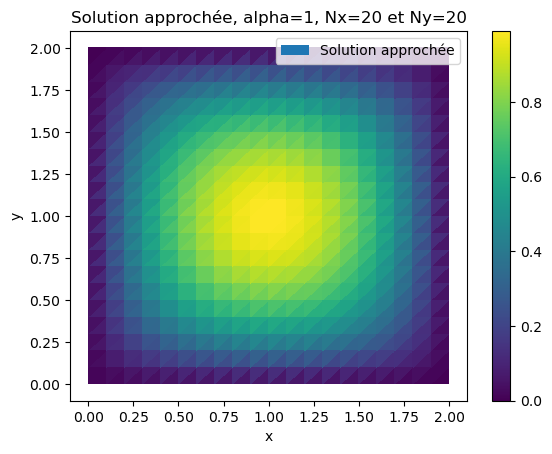

In [47]:
PlotApproximation(1,mu,2,2,20,20)

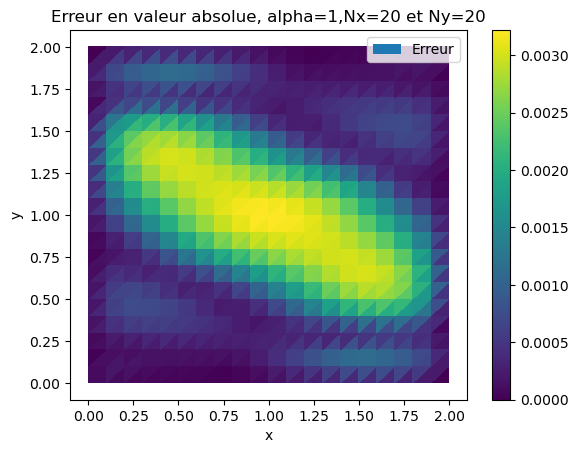

In [48]:
PlotErreur(1,mu,2,2,20,20)

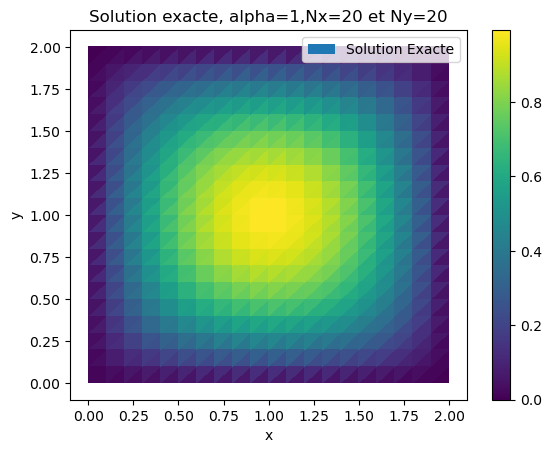

In [49]:
PlotSolutionExacte(1,mu,2,2,20,20)

#### Question c) 

Étant donné un élément $v_h \in V_h(\Omega)$, on note $V = (v_h(s_j^h))_{j=0...N_v}$ le vecteur des valeurs nodales, on a : 
$\newline$
$\| v_h \|_{L^2(\Omega)}^2 = V^TMV$ et $\| \nabla v_h \|_{L^2(\Omega)}^2 = V^TKV$
où $M$ et $K$ sont respectivement la matrice de masse et de ridigité. 

En effet, 
$\|v^h\|_{L^2} = \sqrt{\int_{\Omega} |v(x)|^2 dx}$

$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{\int_{\Omega} | \sum_{i=1}^{N_v} \phi_i(x) v_i^h|^2 dx}$

$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{\int_{\Omega}  \sum_{i=1}^{N_v} \phi_i(x) v_i^h \sum_{j=1}^{N_v} \phi_j(x) \bar{v_j^h} dx}$


$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} v_i^h \bar{v_j^h} M_{ij}}$, par définition de la matrice de masse et par linéarité de l'intégrale. 

$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{V^T \cdot M \cdot V}$


De même, 
$\|\nabla v^h\|_{L^2} = \sqrt{\int_{\Omega} |\nabla v(x)|^2 dx}$

$\Longleftrightarrow$
$\|\nabla v^h\|_{L^2} =\sqrt{\int_{\Omega} | \sum_{i=1}^{N_v} \nabla \phi_i(x) v_i^h|^2 dx}$

$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{\int_{\Omega}  \sum_{i=1}^{N_v} \nabla \phi_i(x) v_i^h \sum_{j=1}^{N_v} \nabla \phi_j(x) \bar{v_j^h} dx}$

$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{\sum_{i=1}^{n} \sum_{j=1}^{n} v_i^h \bar{v_j^h} K_{ij}}$, par définition de la matrice de rigidité et par linéarité de l'intégrale. 


$\Longleftrightarrow$
$\|v^h\|_{L^2} =\sqrt{V^T \cdot K \cdot V}$

Étant donné que la matrice de rigidité n'a pas été définie à proprement parler, nous allons le faire ici, à travers les fonctions $\text{true_Kloc}$ et $\text{true_Rig}$.
Je présente ici deux façons de calculer la matrice de rigidité locale. Une vue en CM (ici $\text{true_Kloc}$) et une sur le polycopié (ici $\text{true_Kloc2}$). Il s'avère que $\text{true_Kloc2}$ est plus efficace donc on utilisera celle-ci pour la construction de la matrice de rigidité globale.

- On utilise la formule suivante (cas bi-dimensionnel) : 

    $K^{\tau} = \frac{1}{4|\tau|}[(s_j-s_{j+1})^t(s_k-s_{k+1})]_{jk}$

In [60]:
def true_Kloc(vtx,mu,e,Lx,Ly) : 
    vtx = np.array(vtx)
    d = len(e) 
    s = vtx[e] #Sommets de l'élément e. 
    K = np.zeros((d,d)) #Matrice carée de taille d x d remplie de 0, à remplir ensuite. 
    #Calcul de l'aire du simplexe : 
    T = LA.norm(np.cross(np.array(vtx[e[0]]) - np.array(vtx[e[1]]), np.array(vtx[e[1]]) - np.array(vtx[e[2]])))/2
    
    for i in range(d) : 
        for j in range(d) : 
            K[i,j] = np.inner(s[(i+1)%3]-s[(i+2)%3],s[(j+1)%3]-s[(j+2)%3])
    K/=(4*T)
    return K 

#Même idée que Kloc, sans le mu. 
def true_Kloc2(vtx,mu,e,Lx,Ly) : 
    vtx=np.array(vtx)
    K = np.zeros(shape=(3,3))
    T = np.linalg.norm(np.cross(vtx[e[0]]-vtx[e[1]], vtx[e[1]]-vtx[e[2]]))/2
    for i in range(3) : 
        ni = np.cross(np.array([0,0,1]), vtx[e[(i+1)%3]]-vtx[e[(i+2)%3]])[:2]
        K[i,i] = np.dot(ni,ni)/( np.dot(vtx[e[i]]-vtx[e[(i+1)%3]],ni)**2)
        for j in range(i+1,3) : 
            nj = np.cross(np.array([0,0,1]),vtx[e[(j+1)%3]]-vtx[e[(j+2)%3]])[:2]
            K[i,j] = np.dot(ni,nj)/ ( np.dot(vtx[e[j]]  - vtx[e[(j+1)%3]], nj)*np.dot(vtx[e[i]] - vtx[e[(i+1)%3]], ni))
            K[j,i]=K[i,j]
    return K/8

Lx=5
Ly=5
Nx = 10 
Ny = 10 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
e = elt[0]
print("true_Kloc(vtx,mu,e,Lx,Ly) =\n", true_Kloc(vtx,mu,e,Lx,Ly))
print("\n")
print("true_Kloc2(vtx,mu,e,Lx,Ly) = \n",true_Kloc2(vtx,mu,e,Lx,Ly))

true_Kloc(vtx,mu,e,Lx,Ly) =
 [[ 0.5 -0.5  0. ]
 [-0.5  1.  -0.5]
 [ 0.  -0.5  0.5]]


true_Kloc2(vtx,mu,e,Lx,Ly) = 
 [[ 0.5 -0.5  0. ]
 [-0.5  1.  -0.5]
 [ 0.  -0.5  0.5]]


In [61]:
def true_Rig(vtx, elt, mu, Lx, Ly) : 
    
    vtx = np.array(vtx)
    elt = np.array(elt)
    
    Nv=len(vtx) #Nombre de sommets. 
    
    Nc=len(elt) #Nombre de cellules. 
    d=len(elt[0])
    
    #print ("Nv={}".format(Nv))
    #print("Nc={}".format(Nc))
    #print("d={}".format(d))

    I = np.zeros(d*d*Nc) 
    J = np.zeros(d*d*Nc) 
    V = np.zeros(d*d*Nc)
    
    k=0 
    
    for q in range(Nc):
        Ml = true_Kloc2(vtx,mu, elt[q],Lx,Ly)
        for l in range(d):
            for m in range(d):
                I[k] = elt[q,l]
                J[k] = elt[q,m]
                V[k] = Ml[l,m]
                k+=1
    return csr_matrix( (V, (I,J) ) , shape=(Nv,Nv) )

Lx=5
Ly=5
Nx = 10 
Ny = 10 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
print(true_Rig(vtx,elt,mu,Lx,Ly).toarray())

[[ 1.  -0.5  0.  ...  0.   0.   0. ]
 [-0.5  2.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  2.  -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  1. ]]


In [62]:
##Test sur la rigidité : 
Lx = 1 
Ly = 1 
Ny = 2 
Nx = 2 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny) 
test = true_Rig(vtx,elt,mu,Lx,Ly)
U = np.ones(test.shape[0])
print("Test sur la ridigité : ", U@test@U)

Lx = 1
Ly = 1 
Ny = 10
Nx = 10 
vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
test2 = true_Rig(vtx,elt,mu,Lx,Ly)
U = np.ones(test2.shape[0])
print("Test sur la rigidité : ", U@test2@U)

new_vtx,new_elt = GeometricRefinement(vtx,elt,6)
test3 = true_Rig(new_vtx,new_elt, mu,Lx,Ly)
U = np.ones(test3.shape[0])
print("Test sur la ridigité : ", U@test3@U)

Test sur la ridigité :  0.0
Test sur la rigidité :  -2.1671553440683056e-13
Test sur la ridigité :  9.489298236076138e-12


Premièrement, concernant $\frac{\| u_h - \Pi u_{ex} \|_{L^2(\Omega)}}{\| \Pi u_{ex} \|_{L^2(\Omega)}}$ :


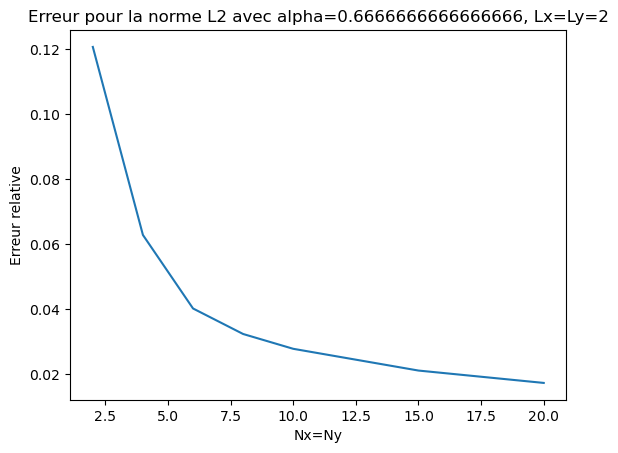

[-0.00438403  0.08675308]


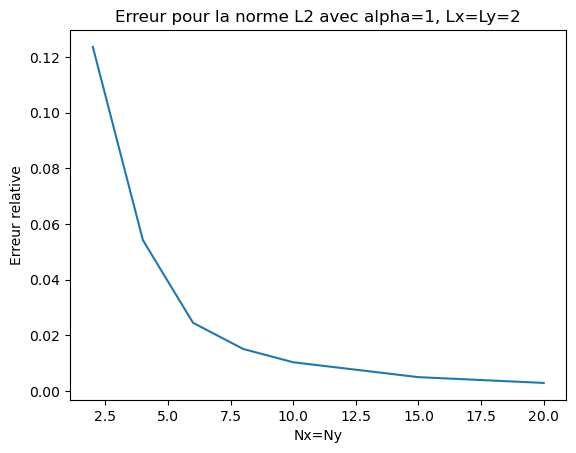

[-0.00505654  0.08060212]


In [34]:
def PlotErreurL2(a,mu,Lx,Ly):
    N_values = [[2,2],[4,4],[6,6], [8,8],[10,10],[15,15],[20,20]] #Par exemple. 
    H = [] #Pour les abcisses : nombre de subdivisions. 
    E = [] #Pour les ordonnées : erreur observée. 
    erreur = 0
    
    for Nx, Ny in N_values:
        H.append(Nx)
        vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
        M = Mass(vtx, elt)
        Uex = np.array([ u(x,y,a,Lx,Ly) for (x,y) in vtx ]) #Solution exacte.
        U = Uh(a,mu,Lx,Ly,Nx,Ny) #Solution approchée.
        erreur = ( (U-Uex).dot(M.dot(U-Uex)) / (Uex.dot(M.dot(Uex))) )
        E.append(erreur**0.5) #Car on avait le carré de la norme. 
        
    plt.plot(H,E)
    plt.title("Erreur pour la norme L2 avec alpha={}, Lx=Ly={}".format(a,Lx))
    plt.xlabel('Nx=Ny')
    plt.ylabel('Erreur relative')
    plt.show()
    return np.polyfit(H, E, 1) #Le 1 dans l'argument signifie régréssion d'ordre 1 (linéaire)

""" 
Si on voulait une echelle log-log : 
- On remplace plt.plot(H,E) par plt.loglog(H,E)
- On remplace return np.polyfit(H, E, 1) par #return np.polyfit(np.log(H), np.log(E), 1)
"""

Lx = 2
Ly = 2 

print(PlotErreurL2(2/3,mu,Lx,Ly))
print(PlotErreurL2(1,mu,Lx,Ly))

Maintenant, concernant $\frac{\| u_h - \Pi u_{ex} \|_{H^1(\Omega)}}{\| \Pi u_{ex} \|_{H^1(\Omega)}}$. 

On utilise le fait que $\| v \|_{H^1(\Omega)} = \sqrt (\| v \|_{\mathbb{L}^2(\Omega)}+\| \nabla v   \|_{\mathbb{L}^2(\Omega)})$. 

[-0.00314487  0.05255048]


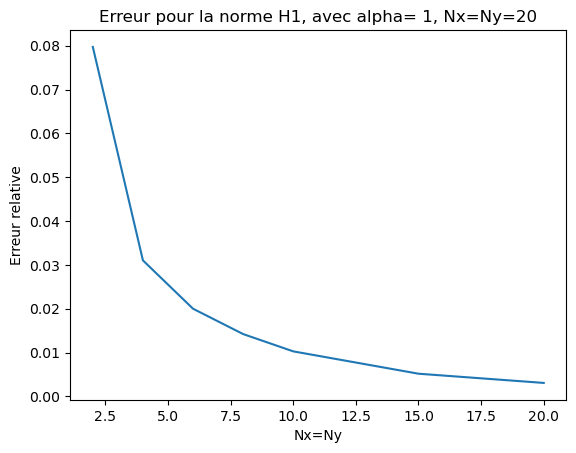

In [65]:
def PlotErreurH1(a,mu,Lx,Ly):
    N_values = [[2,2],[4,4],[6,6], [8,8],[10,10],[15,15],[20,20]] #Par exemple. 
    H = []
    E = []
    erreur = 0
    
    for Nx, Ny in N_values:
        H.append(Nx)
        vtx,elt = GenerateRectangleMesh(Lx,Ly,Nx,Ny)
        M = Mass(vtx, elt)
        K = true_Rig(vtx, elt, mu, Lx, Ly)
        Uex = np.array([ u(x,y,a,Lx,Ly) for (x,y) in vtx ]) #Solution exacte. 
        U = Uh(a,mu,Lx,Ly,Nx,Ny) #Solution approchée.
        erreur = ( ((U-Uex).dot(M.dot(U-Uex) + (U-Uex).dot(K.dot(U-Uex)) ))  / ((Uex.dot(M.dot(Uex))) + (Uex.dot(K.dot(Uex))) ))
        E.append(abs(erreur)**0.5) #On avait le carré de la norme. 
        
    plt.plot(H,E)
    plt.title("Erreur pour la norme H1, avec alpha= {}, Nx=Ny={}".format(a,Nx))
    plt.xlabel('Nx=Ny')
    plt.ylabel('Erreur relative')
    return np.polyfit(H, E, 1)

""" 
Si on voulait une echelle log-log : 
- On remplace plt.plot(H,E) par plt.loglog(H,E)
- On remplace return np.polyfit(H, E, 1) par #return np.polyfit(np.log(H), np.log(E), 1)
"""

Lx = 2
Ly= 2
print(PlotErreurH1(1,mu,Lx,Ly))

$\underline{\text{Conclusion :}}$ La convergence, qu'elle soit en norme $\mathbb{L}^2$ ou $H^1$, semble être quadratique. Autrement dit, l'erreur à l'itération $n+1$ sera égale à une constante près au carré de l'erreur à l'itération $n$.  Ce mode de convergence permet d'obtenir rapidement des résultats relativement proches de la réelle solution (qui n'est pas calculable en pratique). 